In [1]:
import random
import collections
import seaborn as sns
import os
import glob
import numpy as np
import re
import pandas as pd
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score, confusion_matrix, multilabel_confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.linear_model import SGDClassifier
plt.style.use('ggplot')

random.seed(42)
np.random.seed(42)

Создание датафреймов с сырыми данными (столбцы: автор *(по названию папки)*, фамилия автора на русском *(из файла AUTHOR.txt в каждой папке)*, название произведения, текст произведения) и сохранение в csv. Выполняется поиск произведений в папках texts/{ds}_txt/\*\* (вместо {ds} — TRAIN или TEST).

In [2]:
for ds in ['train', 'test']:
    # Находим все текстовые файлы
    FILE_PATHS = glob.glob(f'texts/{ds.upper()}_txt/**/*.txt', recursive=True)
    # Находим файлы с информацией о каждом авторе (AUTHOR.txt, сейчас там только фамилия на русском)
    AUTHOR_INFO_PATHS = glob.glob(f'texts/{ds.upper()}_txt/**/AUTHOR.txt', recursive=True)
    
    # Создаем словарь "автор" (название папки) - "фамилия" (из файла AUTHOR.txt в этой папке) 
    AUTHOR__RUS_SURNAME__DICT = dict()
    for path in AUTHOR_INFO_PATHS:
        with open(path, 'r', encoding='utf-8') as f:
            AUTHOR__RUS_SURNAME__DICT[path.split("\\")[-2]] = f.readline().split(':')[-1]
    
    # Создаем словарь "название произведения" (по названию файла) - "путь к файлу"
    TITLE_PATH_DICT = {path.split("\\")[-1].split(".")[0] : path for path in FILE_PATHS}
    del TITLE_PATH_DICT['AUTHOR']
    # Создаем словарь "название произведения" - "автор" 
    TITLE_AUTHOR_DICT = {path.split("\\")[-1].split(".")[0] : path.split("\\")[-2] for path in FILE_PATHS}
    del TITLE_AUTHOR_DICT['AUTHOR']
    
    # Создаем датафрейм и сохраняем
    dataset_list = []
    for title, path in TITLE_PATH_DICT.items():
        with open(path, 'r', encoding='utf-8') as f:
            text = f.read()[:-2000]
        author = TITLE_AUTHOR_DICT[title]
        dataset_list.append({
            'author': author,
            'author_surname': AUTHOR__RUS_SURNAME__DICT[author],
            'work_title': title,
            'text': text
        })
    df_raw = pd.DataFrame(dataset_list)
    df_raw.to_csv(f'datasets/raw_{ds}.csv', index=False)

In [3]:
df_train_raw = pd.read_csv('datasets/raw_TRAIN.csv')
df_test_raw = pd.read_csv('datasets/raw_TEST.csv')

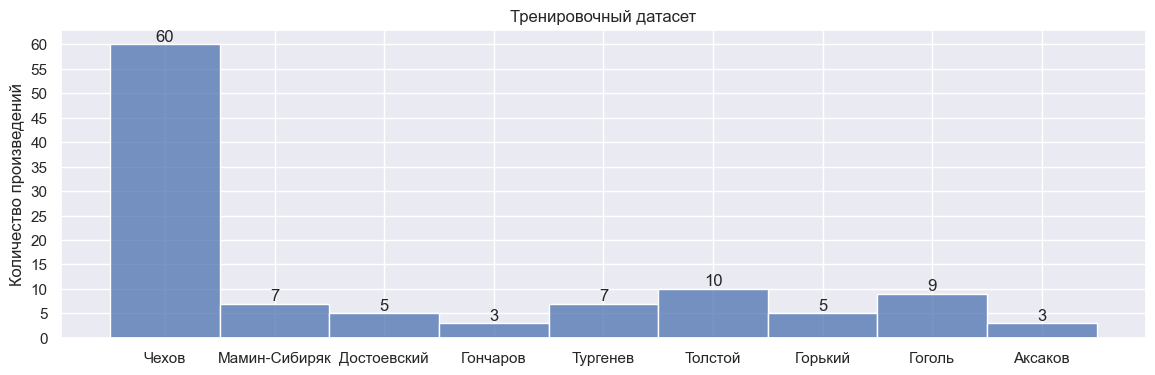

In [4]:
sns.set(rc={'figure.figsize':(14,4)})
y = sns.histplot(data=df_train_raw, x='author_surname')
y.set(xlabel='', ylabel='Количество произведений')
y.bar_label(y.containers[0])
plt.title('Тренировочный датасет')
plt.yticks(np.arange(0, 61, 5))
plt.show();

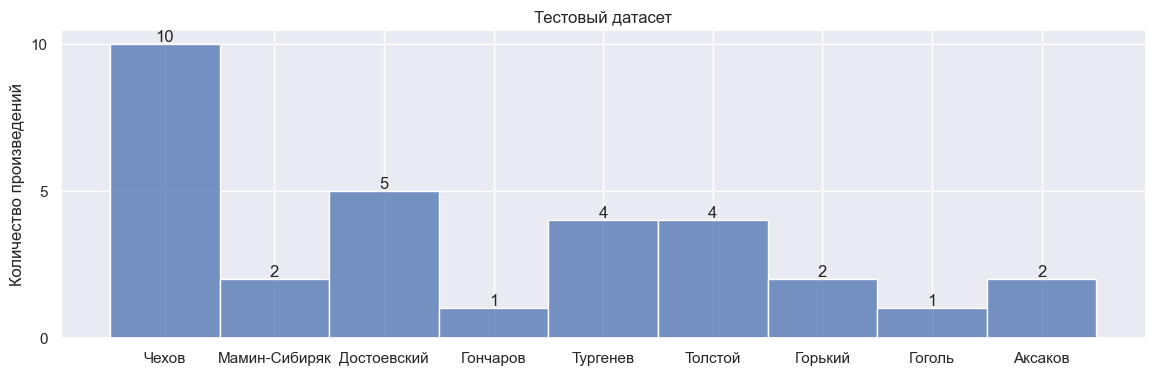

In [5]:
sns.set(rc={'figure.figsize':(14,4)})
y = sns.histplot(data=df_test_raw, x='author_surname')
y.set(xlabel='', ylabel='Количество произведений')
y.bar_label(y.containers[0])
plt.title('Тестовый датасет')
plt.yticks(np.arange(0, 12, 5))
plt.show();

In [6]:
df_train_raw.sample()

,author,author_surname,work_title,text
78,ivan-turgenev,Тургенев,rudin,I \n Было тихое летнее утро. Солнце уже доволь...


### Разбиение произведений на отрывки по 100 предложений

In [7]:
# Вспомогательная функция для получения в строке string 
# индекса конца предложения после символа с индексом start.
def get_ind_of_sentence_end(string, start=0):
    ind = start
    for char in string[start:]:
        if char in ".?!…":
            return ind
        ind += 1
    return None

# Разбивает строку на предложения (знаки завершения сохраняются).
def string_to_list_of_sentences(string):
    sentences = []
    string = string.replace('...', '…')
    start = 0
    while start < len(string):
        end_ind = get_ind_of_sentence_end(string, start=start)
        if end_ind is None:
            break
        sentence = string[start:end_ind+1].strip()
        if len(sentence) == 1 and len(sentences) > 0:
            sentences[-1] = sentences[-1] + sentence
        else:
            sentences.append(sentence)
        start = end_ind+1
    return sentences

# Разбивает текст на отрывки по excerpt_num_of_sentences предложений.
# Последний отрывок не включается, если он имеет длину 
# меньше excerpt_num_of_sentences предложений.
def text_to_excerpts(text, excerpt_num_of_sentences) -> list:
    sentences = string_to_list_of_sentences(text)
    excerpts = []
    for idx in range(excerpt_num_of_sentences, len(sentences)+1, excerpt_num_of_sentences):
        excerpt = ' '.join(sentences[idx-excerpt_num_of_sentences:idx])
        excerpts.append(excerpt)
    return excerpts

In [8]:
example = "Раз. Два! Три? Четыре… Пять?! Шесть, семь, восемь. Девять!!!"
string_to_list_of_sentences(example) # Пример

['Раз.',
 'Два!',
 'Три?',
 'Четыре…',
 'Пять?!',
 'Шесть, семь, восемь.',
 'Девять!!!']

In [9]:
text_to_excerpts(example, 2) # Пример

['Раз. Два!', 'Три? Четыре…', 'Пять?! Шесть, семь, восемь.']

In [10]:
# Из датафрейма с текстами создает датафрейм с отрывками 
# по excerpt_num_of_sentences предложений.
def df_with_texts_to_df_with_excerpts(df, excerpt_num_of_sentences=100):
    dataset_list = []
    with tqdm(total=df.shape[0]) as pbar:
        for index, row in df.iterrows():
            excerpts = text_to_excerpts(row['text'], excerpt_num_of_sentences)
            for i in range(len(excerpts)):
                excerpt = excerpts[i]
                dataset_list.append({
                    'author': row['author'],
                    'author_surname': row['author_surname'],
                    'work_title': row['work_title'],
                    'excerpt_num': i,
                    'text': excerpt
                })
            pbar.update(1)
    return pd.DataFrame(dataset_list)

In [11]:
df_train = df_with_texts_to_df_with_excerpts(df_train_raw)
df_test = df_with_texts_to_df_with_excerpts(df_test_raw)

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.82it/s]


In [12]:
df_train.to_csv('datasets/TRAIN_100sentences.csv', index=False)
df_test.to_csv('datasets/TEST_100sentences.csv', index=False)

In [13]:
df_train = pd.read_csv('datasets/TRAIN_100sentences.csv')
df_test = pd.read_csv('datasets/TEST_100sentences.csv')

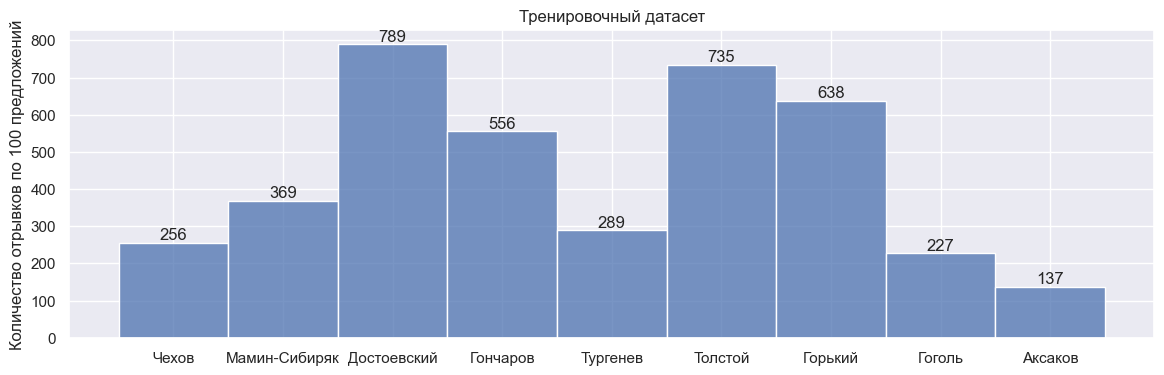

In [14]:
sns.set(rc={'figure.figsize':(14,4)})
y = sns.histplot(data=df_train, x='author_surname')
y.set(xlabel='', ylabel='Количество отрывков по 100 предложений')
y.bar_label(y.containers[0])
plt.title('Тренировочный датасет')
plt.show();

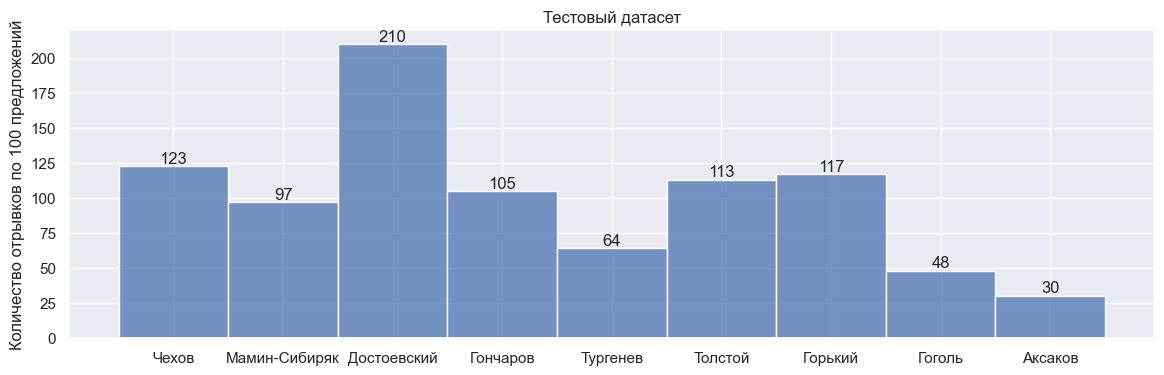

In [15]:
sns.set(rc={'figure.figsize':(14,4)})
y = sns.histplot(data=df_test, x='author_surname')
y.set(xlabel='', ylabel='Количество отрывков по 100 предложений')
y.bar_label(y.containers[0])
plt.title('Тестовый датасет')
plt.show();

In [16]:
df_test.shape

(907, 5)

### Добавление столбца с леммами 

In [17]:
# patterns = "[A-Za-z0-9!#$%&'()*+,.…«»/:;<=>?@[\]^_`{|}~—\"\-]+"
patterns = r'[^а-яё ]+'
morph = MorphAnalyzer()

def lemmatize(doc, remove_stop_words=True):
    doc = re.sub(patterns, ' ', doc.lower()).strip()
    tokens = []
    stopwords_ru = stopwords.words("russian") if remove_stop_words else ''
    for token in doc.split():
        if token and token.strip() not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
    return tokens

In [18]:
for df in [df_train, df_test]:
    with tqdm(total=df.shape[0]) as pbar:
        df['lemmas'] = df['text'].apply(
            lambda x: (' '.join(lemmatize(x)), pbar.update(1))[0]
        )

100%|████████████████████████████████████████████████████████████████████████████████| 907/907 [01:03<00:00, 14.32it/s]


In [19]:
df_train.to_csv('datasets/TRAIN_100sentences_lemmatized.csv', index=False)
df_test.to_csv('datasets/TEST_100sentences_lemmatized.csv', index=False)

In [2]:
df_train = pd.read_csv('datasets/TRAIN_100sentences_lemmatized.csv')
df_test = pd.read_csv('datasets/TEST_100sentences_lemmatized.csv')

In [3]:
df_train.sample(3)

,author,author_surname,work_title,excerpt_num,text,lemmas
1760,ivan-goncharov,Гончаров,obryv,20,"Она робка, скромна или горда, неприступна или ...",робкий скромный гордый неприступный нежный пос...
3016,maksim-gorkii,Горький,mat,22,"- Кланяется вам Павел, здоров и весел, как тол...",кланяться павел здоровый весёлый тесно народ с...
1770,ivan-goncharov,Гончаров,obryv,30,"Она догадывается, что вон эта женщина торопитс...",догадываться вон этот женщина торопиться узел ...


In [4]:
df_test.sample(3)

,author,author_surname,work_title,excerpt_num,text,lemmas
407,fedor-dostoevskii,Достоевский,prestuplenie-i-nakazanie,133,"Раскольников тотчас сделал вид, что как будто ...",раскольник тотчас сделать вид заметить смотрет...
687,lev-tolstoi,Толстой,khadzhi-murat,24,Вы не испугаетесь? — обратился он к Марье Дмит...,испугаться обратиться марья дмитриевич бояться...
33,anton-chekhov,Чехов,bezotcovshina,29,Саша (входя) . Боже мой! Когда же всему этому ...,саша входить бог весь этот конец наказать пьян...


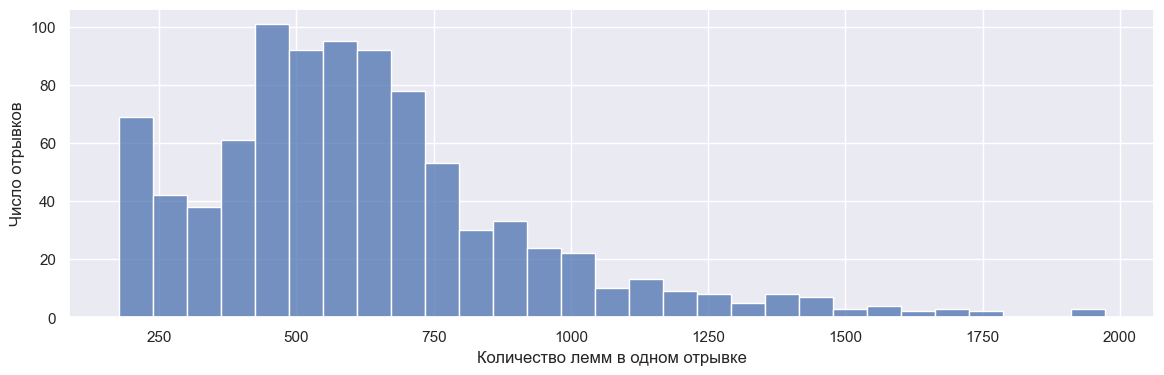

In [29]:
sns.set(rc={'figure.figsize':(14,4)})
hst = sns.histplot(
    data=df_test['lemmas'].apply(lambda x: len(x.split())),
)
hst.set(xlabel='Количество лемм в одном отрывке')
hst.set(ylabel='Число отрывков')
plt.show();

## Признаки

In [6]:
%%time
patterns = r'[^а-яё.?!…,:;—()\"\'\- ]+'
char_vec_ct = TfidfVectorizer(analyzer='char', ngram_range=(1, 4), sublinear_tf=True) 
ctX_train = char_vec_ct.fit_transform(
    df_train['text'].apply(lambda x: re.sub(patterns, '', x.lower()))
)

CPU times: total: 43.2 s
Wall time: 43.2 s


In [7]:
%%time
char_vec_wl = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), sublinear_tf=True) 
wlX_train = char_vec_wl.fit_transform(df_train['lemmas'])

CPU times: total: 1.92 s
Wall time: 1.93 s


In [8]:
y_train = df_train['author']
X_train = hstack([ctX_train, wlX_train])

## Обучение

In [9]:
clf = SGDClassifier(random_state=42, max_iter=50000, verbose=0, alpha=0.0001,
                    n_jobs=10, loss='modified_huber')
clf.fit(X_train, y_train)

SGDClassifier(loss='modified_huber', max_iter=50000, n_jobs=10, random_state=42)

#### Получение матрицы признаков для тестового датасета 

In [10]:
def get_features(df_test):
    if 'author' in df_test.columns:
        y_test = df_test.author
    else:
        y_test = None
    
    wlX_test = char_vec_wl.transform(df_test['lemmas'])
    ctX_test = char_vec_ct.transform(df_test['text'].apply(lambda x: re.sub(patterns, '', x.lower())))
    
    cX_test =  hstack([ctX_test, wlX_test])
    return cX_test, y_test

#### Предсказываем на тестовом датасете

In [11]:
%%time
X_test, y_test = get_features(df_test)

CPU times: total: 10.7 s
Wall time: 9.15 s


#### F1-score

In [12]:
pred_test = clf.predict(X_test)
f1_score(y_test, pred_test, average='weighted')

0.9988957361194846

In [13]:
roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr')

0.9999299963257643

#### Для сравнения, простейший бейзлайн (мажоритарный класс)

In [14]:
def baseline(df_train, df_test):
    pred = df_train.groupby(by='author').count()['text'].idxmax()
    return [pred for i in range(df_test.shape[0])]

In [15]:
pred_test_baseline = baseline(df_train, df_test)
f1_score(y_test, pred_test_baseline, average='weighted')

0.08705788757293072

#### Confusion matrix

In [16]:
AUTHOR__RUS_SURNAME__DICT = dict()
for author in y_test.unique():
    AUTHOR__RUS_SURNAME__DICT[author] =\
        df_train[df_train['author'] == author]['author_surname'].iloc[0]

In [17]:
labels = y_test.unique()
labels_r = np.array(list(map(lambda x: AUTHOR__RUS_SURNAME__DICT[x], labels)))
labels_r

array(['Чехов', 'Мамин-Сибиряк', 'Достоевский', 'Гончаров', 'Тургенев',
       'Толстой', 'Горький', 'Гоголь', 'Аксаков'], dtype='<U13')

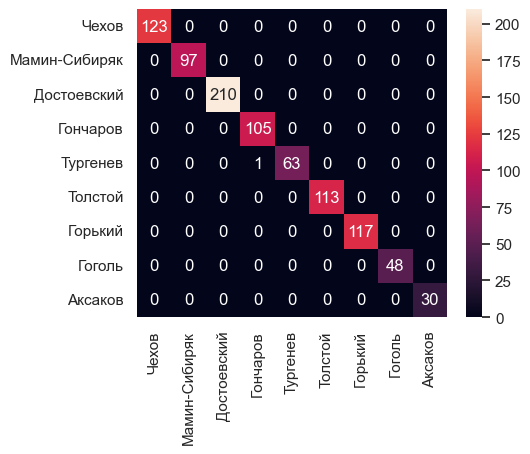

In [18]:
sns.set(rc={'figure.figsize':(5,4)})
sns.heatmap(
    confusion_matrix(y_test, pred_test, labels=labels),
    xticklabels=labels_r,
    yticklabels=labels_r,
    annot=True,
    fmt="d"
)
plt.show();

#### Список ошибочно классифицированных объектов

In [20]:
def false_predictions(df, y_true, y_pred):
    res = pd.DataFrame(np.vstack([y_true, y_pred]).T, columns=['y_true', 'y_pred'])
    res = pd.concat([res, df], axis=1)
    res = res.drop('author', axis=1)
    res['lemmas_num'] = res['lemmas'].apply(lambda x: len(x.split()))
    return res[res.y_true != res.y_pred]

false_predictions(df_test, y_test, pred_test)

,y_true,y_pred,author_surname,work_title,excerpt_num,text,lemmas,lemmas_num
584,ivan-turgenev,ivan-goncharov,Тургенев,nakanune,28,Это дело нельзя разом сделать; надо хорошенько...,это дело разом сделать хорошенько обдумать нуж...,320


#### Важность признаков (топ-15)

In [21]:
def print_top_N_ngrams_by_weight(first_column=0, topN=100, ncolumns=1):
    top_words = []
    for i in range(9):
        top_words_of_author = np.concatenate(
            [char_vec_ct.get_feature_names_out(), char_vec_wl.get_feature_names_out()]
        )[clf.coef_[i].argsort()[-topN:][::-1]]
        coefs = np.sort(clf.coef_[i])[-topN:][::-1]

        tmp = np.empty(topN, dtype=object)
        tmp[:] = list((map(tuple, np.vstack([top_words_of_author, coefs]).T)))
        top_words.append(tmp)

    for author in y_train.unique()[first_column:first_column+ncolumns]:
        print(''.ljust(5) + AUTHOR__RUS_SURNAME__DICT[author].ljust(35), end='')
    print()
    i = 1
    for row in np.array(top_words)[first_column:first_column+ncolumns].T:
        for word, coef in row:
            print(f'{i}.'.ljust(5) + f'<{word}>'.ljust(25, '·') + f'{"%.2f" % coef}'.ljust(10), end='')
        i+= 1
        print('')

In [22]:
print_top_N_ngrams_by_weight(first_column=0, topN=15, ncolumns=3)

     Чехов                                   Мамин-Сибиряк                           Достоевский                        
1.   <урбенин>················1.10      1.   <привал>·················0.91      1.   <алеш>···················1.30      
2.   <ольга>··················0.88      2.   <галактион>··············0.86      2.   <вскричать>··············1.15      
3.   <чёрт>···················0.85      3.   <привалов>···············0.81      3.   <ужасно>·················1.01      
4.   <акимович>···············0.80      4.   <её>·····················0.74      4.   <митя>···················1.00      
5.   <пауза>··················0.78      5.   <зося>···················0.65      5.   <ваня>···················0.95      
6.   <чебутыкин>··············0.68      6.   <завод>··················0.61      6.   <князь>··················0.89      
7.   <аркадин>················0.67      7.   <любочка>················0.61      7.   <лишь>···················0.85      
8.   <лопахин>················0.

In [23]:
print_top_N_ngrams_by_weight(first_column=3, topN=15, ncolumns=3)

     Гончаров                                Тургенев                                Толстой                            
1.   <обломов>················1.71      1.   <промолвить>·············1.89      1.   <левин>··················1.29      
2.   <райский>················1.46      2.   <словно>·················1.48      2.   <пьер>···················1.19      
3.   <фр>·····················0.98      3.   <санин>··················1.16      3.   <нехлюдов>···············1.13      
4.   <илья>···················0.85      4.   <рудин>··················1.13      4.   <каренин>················1.08      
5.   <бабушка>················0.85      5.   <базар>··················0.94      5.   <нынче>··················0.87      
6.   <вера>···················0.85      6.   <лаврецкий>··············0.85      6.   <вронский>···············0.86      
7.   <всё>····················0.85      7.   <возразить>··············0.82      7.   <ростов>·················0.84      
8.   <захар>··················0.

In [24]:
print_top_N_ngrams_by_weight(first_column=6, topN=15, ncolumns=3)

     Горький                                 Гоголь                                  Аксаков                            
1.   <самгин>·················1.60      1.   <чичиков>················1.81      1.   <евсеевич>···············0.76      
2.   <клим>···················1.26      2.   <хлестак>················0.93      2.   <сестрица>···············0.76      
3.   <пепел>··················0.85      3.   <городничий>·············0.73      3.   <также>··················0.70      
4.   <сатина>·················0.77      4.   <черта>··················0.73      4.   <надобный>···············0.66      
5.   <лука>···················0.74      5.   <вши >···················0.71      5.   <параша>·················0.57      
6.   <снова>··················0.64      6.   <чичи>···················0.68      6.   <рубановский>············0.50      
7.   <самг>···················0.62      7.   < чич>···················0.66      7.   <шушерин>················0.48      
8.   <мгин>···················0.

### Для сравнения, один из классических методов (Дельта Бёрроуза)

In [25]:
from corpus import Corpus
import burrows_delta

train_crp = Corpus(
    authors=df_train['author'].to_list(), 
    books=df_train.apply(lambda row: f'{row.work_title}_{row.excerpt_num}', axis=1).to_list(), 
    tokens=df_train['lemmas'].to_list()
)

test_crp = Corpus(
    authors=df_test['author'].to_list(), 
    books=df_test.apply(lambda row: f'{row.work_title}_{row.excerpt_num}', axis=1).to_list(), 
    tokens=df_test['lemmas'].to_list()
)

In [26]:
%%time
df_b_delta = burrows_delta.calculate_burrows_delta(train_crp, test_crp, vocab_size=5000)
pred_test_b_delta = df_b_delta.T.columns[df_b_delta.apply(np.argmin, axis=0)]

CPU times: total: 10.6 s
Wall time: 10.6 s


In [27]:
f1_score(y_test, pred_test_b_delta, average='macro')

0.2777859786003918

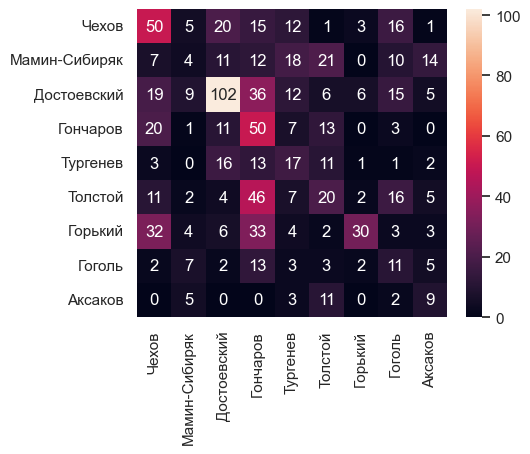

In [28]:
sns.set(rc={'figure.figsize':(5,4)})
sns.heatmap(
    confusion_matrix(y_test, pred_test_b_delta, labels=labels),
    xticklabels=labels_r,
    yticklabels=labels_r,
    annot=True,
    fmt="d"
)
plt.show();